## quick recap

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_swiss_roll
from helper_plot import hdr_plot_style
hdr_plot_style()

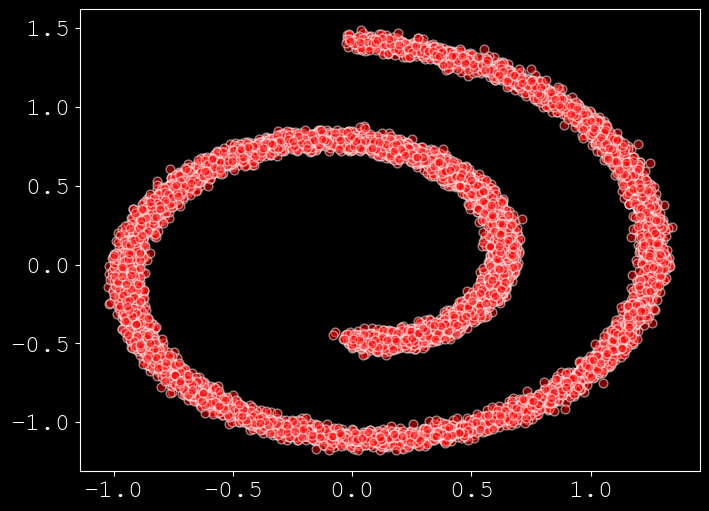

In [2]:
def sample_batch(size, noise=0.3):
    x, _ = make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0

data = sample_batch(10**4).T
plt.figure(figsize=(8, 6))
plt.scatter(*data, alpha=0.5, color='red', edgecolor='white', s=40)

In [3]:
import torch
import torch.nn as nn
from torch import optim

In [4]:
def denoising_score_matching(scorenet, samples, sigma=0.01):
    '''
    samples: shape of [B, dim]
    '''
    eps = torch.randn_like(samples) * sigma # [B, dim]
    perturbed_samples = samples + eps 
    
    target = -1 / (sigma ** 2) * (eps) 
    scores = scorenet(perturbed_samples)
    
    # flatten
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)

    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1).mean(dim=0)
    
    return loss

def plot_gradients(model, data, plot_scatter=True):
    xx = np.stack(np.meshgrid(np.linspace(-1.5, 2.0, 50), np.linspace(-1.5, 2.0, 50)), axis=-1).reshape(-1, 2)
    scores = model(torch.from_numpy(xx).float()).detach()

    scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)

    plt.figure(figsize=(16,12))
    if (plot_scatter):
        plt.scatter(*data, alpha=0.3, color='red', edgecolors='white', s=40)
    
    plt.quiver(xx.T[0], xx.T[1], scores_log1p[:,0], scores_log1p[:,1], width=0.002, color='white')
    plt.xlim(-1.5, 2.0)
    plt.ylim(-1.5, 2.0)

In [5]:
# Score model
model = nn.Sequential(
    nn.Linear(2, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 2)
    )

optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T).float()

def train():
    for t in range(5000):
        loss = denoising_score_matching(model, dataset)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [6]:
# train()
# plot_gradients(model, data)

## Sampling

In [7]:
def sample_langevin(model, x=None, n_steps=10, eps=5e-3, decay=.9, temperature=1.0):
    if (x is None):
        x = torch.randn(2)
    
    x_sequence = [x.unsqueeze(0)]
    for _ in range(n_steps):
        z_t = torch.rand(x.size())
        x = x + (eps / 2) * model(x) + (np.sqrt(eps) * temperature * z_t)
        x_sequence.append(x.unsqueeze(0))
        eps *= decay
    
    return torch.cat(x_sequence)

def plot_langevin():
    samples = sample_langevin(model).detach()
    plot_gradients(model, data)
    plt.scatter(samples[:, 0], samples[:, 1], color='green', edgecolor='white', s=50)

    deltas = (samples[1:] - samples[:-1])
    deltas = deltas - deltas / np.linalg.norm(deltas, keepdims=True, axis=-1) * 0.04
    for i, arrow in enumerate(deltas):
        plt.arrow(samples[i, 0], samples[i, 1], arrow[0], arrow[1], width=1e-3, head_width=2e-2, color='green', linewidth=1)
        plt.text(samples[i, 0], samples[i, 1], f'{i}', color='red')
    
# plot_langevin()

## Diffusion Process

### Forward process

In [8]:
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == 'quad':
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == 'sigmoid':
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    
    return betas

def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)

In [9]:
# parameters for diffusion
n_steps = 100

betas = make_beta_schedule(schedule='sigmoid', n_timesteps=n_steps, start=1e-5, end=1e-2)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)

one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

In [12]:
# forward process를 beta schedule에 따라 진행하여 q(x_t | x_0)를 바로 계산할 수 있음.
def q_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

def plot_diffusion():
    _, axs = plt.subplots(1, 10, figsize=(28, 3))
    for i in range(10):
        q_i = q_sample(dataset, torch.tensor([i * 10]))
        axs[i].scatter(q_i[:, 0], q_i[:,1], s=10)
        axs[i].set_axis_off()
        axs[i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

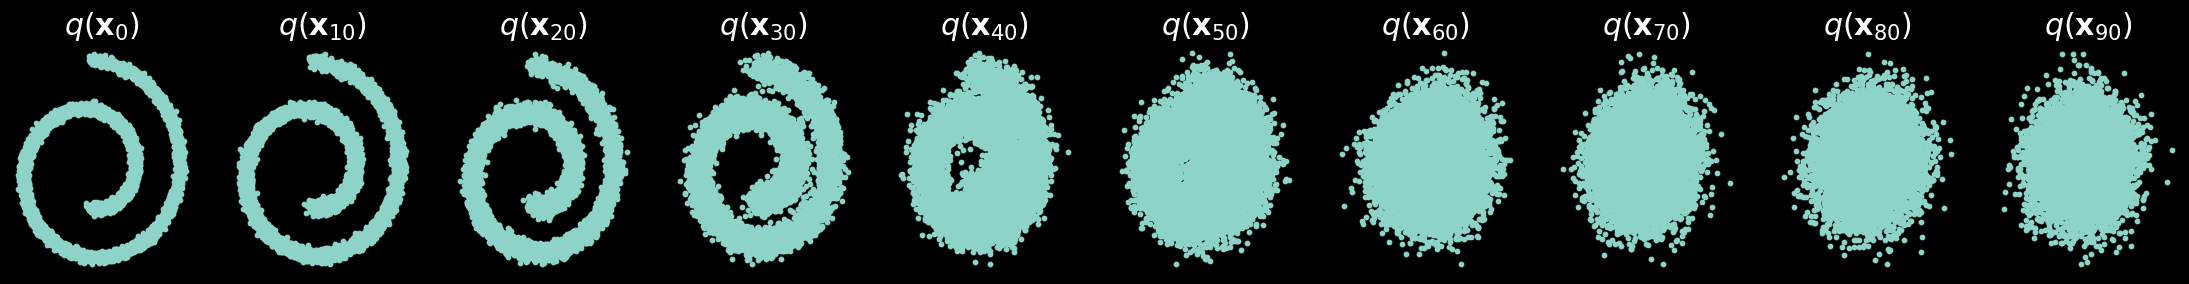

In [13]:
plot_diffusion()

### Reverse Process

In [14]:
import torch.nn.functional as F

# f(X_t, t_\theta)
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super().__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()
    
    def forward(self, x, t):
        out = self.lin(x)
        gamma = self.embed(t)
        out = gamma.view(-1, self.num_out) * out
        return out

class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super().__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = nn.Linear(128, 4)
    
    def forward(self, x_t, t):
        x = F.softplus(self.lin1(x_t, t))
        x = F.softplus(self.lin2(x, t))
        return self.lin3(x, t)

def p_mean_variance(model, x_t, t):
    out = model(x_t, t)
    mean, log_var = torch.split(out, 2, dim=-1)
    # var = torch.exp(log_var)
    return mean, log_var

**model** $f_\theta(x_t, t)$

$$ f_\theta(x_t, t): (x_t, t) \mapsto \left ( \mu_\theta(x_t, t), \log \Sigma_\theta(x_t, t) \right)$$


In [15]:
model = ConditionalModel(n_steps)

In [16]:
def p_sample(model, x, t):
    mean, log_var = p_mean_variance(model, x, torch.tenosr(t))
    noise = torch.randn_like(x)
    sample = mean + torch.exp(0.5 * log_var) * noise
    return (sample)

def p_sample_loop(model, shape):
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for t in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, t)
        x_seq.append(cur_x)
    return x_seq

## Training

By using Jensen's inequality on the previous expression, we can see that the training may be performed by optimizing the variational bound on **negative log-likelihood**

$$\mathbb E [-\log p_\theta(x_0)] \leq \mathbb E_q \left[ -\log \frac {p_\theta(x_{0:T})} {q(x_{1:T}  | x_0)}\right]$$
$$\mathcal L = \mathbb E_q \left[
-\log p(x_T) - \sum_{t \geq 1}\log \frac {p_\theta(x_{t-1} | x_t)} {q(x_t | x_{t-1})}

\right]$$


Therefore, efficient training is allowed by optimizing random terms o $\mathcal{L}$ with gradient descent

Further improvements, proposed by Ho et al. [1], come from variance reduction by rewriting $\mathcal{L}$ as a sum of KL divergence

$$
\begin{align}
&\mathcal{L} = \mathbb E_q \left[\mathcal L_T + \sum_{t > 1} \mathcal L_{t-1} + \mathcal L_0\right]\\

&\mathcal L_T = D_{\text{KL}}(q(x_T | x_0) || p(x_t)) \\
&\mathcal L_{t-1} = D_{\text{KL}}(q(x_{t-1} | x_t, x_0) || p_\theta(x_{t-1} | x_t))\\
&\mathcal L_0 = -\log p_\theta(x_0 | x_1)
&\end{align}
$$

$$D_{\text{KL}} \left( \mathcal{N}(\mu_1, \sigma_1^2) \parallel \mathcal{N}(\mu_2, \sigma_2^2) \right) = \log \frac{\sigma_2}{\sigma_1} + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2\sigma_2^2} - \frac{1}{2}$$

define $v := \log\sigma^2$

$$
\begin{aligned}
&=\frac{v_2 - v_1} 2 + \frac{e^{v_1} + (\mu_1 - \mu_2)^2} {2e^{v_2}} - \frac 1 2
\\&= 0.5*\left(
- 1 + v_2 - v_1 + e^{v_1 - v_2} + \frac {(\mu_1 - \mu_2)^2} {e^{v_2}}
\right)
\end{aligned}
$$

In [19]:
def normal_kl(mean1, logvar1, mean2, logvar2):
    kl = 0.5 * (-1.0 + logvar2 - logvar1 + torch.exp(logvar1 - logvar2) + ((mean1 - mean2) ** 2) * torch.exp(-logvar2))
    return kl

def approx_standard_normal_cdf(x):
    return 0.5 * (1.0 + torch.tanh(torch.tensor(np.sqrt(2.0 / np.pi)) * (x + 0.044715 * torch.pow(x,3))))

# TODO: 아직 이게 뭐하는건지 잘 모르겠네
def discretized_gaussian_log_likelihood(x, means, log_scales):
    # Asuumes data is integeres [0, 255] recaled to [-1, 1]
    centered_x = x - means 
    inv_stdv = torch.exp(-log_scales) # 1 / sigma

    plus_in = inv_stdv * (centered_x + 1. / 255.) # (x + 1/255) / sigma
    cdf_plus = approx_standard_normal_cdf(plus_in)

    min_in = inv_stdv * (centered_x -1. / 255.)
    cdf_min = approx_standard_normal_cdf(min_in)
    
    log_cdf_plus = torch.log(torch.clamp(cdf_plus, min=1e-12))
    log_one_minus_cdf_min = torch.log(torch.clamp(1 - cdf_min, min=1e-12))

    cdf_delta = cdf_plus - cdf_min
    log_probs = torch.where(x < -0.999, log_cdf_plus, torch.where(x > 0.999, log_one_minus_cdf_min, torch.log(torch.clamp(cdf_delta, min=1e-12))))

    return log_probs

In [50]:
def loss_variational(model, x_0):
    batch_size = x_0.shape[0]

    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long() # antithentic sampling(DDIM)

    # Perform diffusion for step t
    x_t = q_sample(x_0, t)

    # Compute the true mean and variance
    true_mean, true_var = q_posterior_mean_variance(x_0, x_t, t)

(array([55., 51., 45., 55., 44., 44., 55., 45., 51., 55.]),
 array([ 0. ,  9.9, 19.8, 29.7, 39.6, 49.5, 59.4, 69.3, 79.2, 89.1, 99. ]),
 <BarContainer object of 10 artists>)

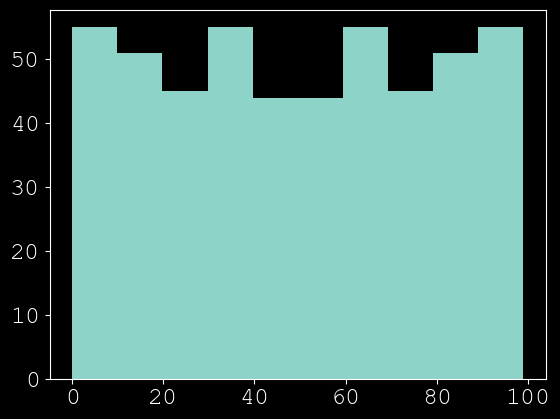

In [49]:
batch_size = 500
t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()

plt.hist(t)

(array([46., 52., 60., 42., 58., 58., 45., 53., 53., 33.]),
 array([ 0. ,  9.9, 19.8, 29.7, 39.6, 49.5, 59.4, 69.3, 79.2, 89.1, 99. ]),
 <BarContainer object of 10 artists>)

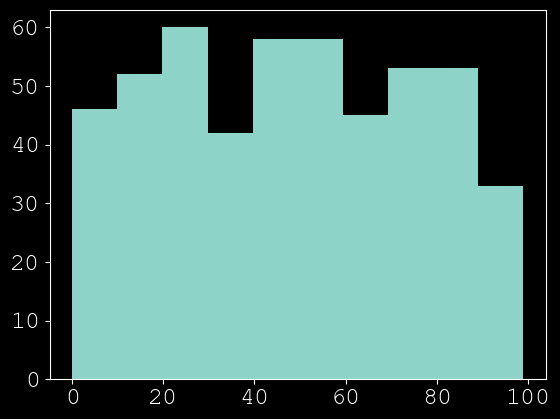